<a href="https://colab.research.google.com/github/benchov/Machine_Learning_for_Trading_Knowledge/blob/main/Market_Analysis_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install kneed
!pip install alpaca-trade-api
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Market Analysis for Paper Trading




0.   Connect to the market data provider api
1.   Get Data
2.   Filter available assets in Alpaca Market
3.   Find Cointegrated pairs for Statistical Arbitrage
4.   Pick cointegrated pairs and detect trend with HMM Clustering
5.   Detect entry point, target price and stop price by the chart
6.   Create trading report.



#### Imports

In [12]:
import random
from datetime import datetime
# remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data extraction and management
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
from pandas_datareader.nasdaq_trader  import get_nasdaq_symbols

# feature engineering
from sklearn.preprocessing import StandardScaler

# machine learing related imports
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# cointegration and statistic
from statsmodels.tsa.stattools import coint
import statsmodels.api as simplefilter

# reporting and visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# market data
import alpaca_trade_api as alpaca
import yfinance as yf

#### Connect to the market data provider

In [14]:
api = alpaca.REST(key_id, secret_key, 'https://paper-api.alpaca.markets')
# api.get_account()

#### Get Data

In [15]:
# get list of available stocks 
asset_list =api.list_assets()
asset_list = [asset.symbol for asset in asset_list if (asset.status == 'active') and (asset.tradable == True) and (asset.shortable == True) and (asset.fractionable == True)]
len(asset_list), asset_list[:10]
asset_list = random.sample(population=asset_list, k=200)
len(asset_list)

200

In [16]:
start_date = '2020-01-01'
end_date = '2022-12-27'
data = yf.download(asset_list, start_date, end_date)
data = data['Adj Close']

[*********************100%***********************]  200 of 200 completed

1 Failed download:
- LGF.B: No data found for this date range, symbol may be delisted


#### Clear Data

In [17]:
data.dropna(inplace=True, axis=1)
data = data.iloc[100:400]
data.head()

,ABBV,ABCB,ADPT,AGRO,AGZ,AHT,AIR,ALG,AMCX,AMED,...,VWOB,WDAY,WLK,WRLD,WTBA,WTI,XLP,XME,XNCR,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-27,80.548439,25.612297,39.080002,4.095264,116.347672,82.0,21.27,105.854248,30.020000,182.889999,...,67.497337,170.380005,47.434708,68.500000,17.048409,2.74,54.543736,20.579149,32.169998,133.559601
2020-05-28,80.593185,23.743839,38.919998,4.143672,116.309212,83.0,20.74,102.423950,28.610001,190.929993,...,67.399673,182.559998,46.166809,67.080002,16.232697,2.61,55.027328,20.250654,31.000000,135.991730
2020-05-29,82.956474,23.216833,38.700001,4.172716,116.511131,69.0,20.17,102.137283,28.270000,192.050003,...,67.674950,183.429993,46.166809,66.500000,15.987984,2.61,55.083130,20.134716,30.250000,137.252090
2020-06-01,81.192963,23.053947,39.070000,4.221124,116.483215,69.0,20.08,99.290253,29.889999,189.050003,...,68.015526,177.960007,46.650742,66.500000,15.942670,2.85,55.464424,20.617794,30.459999,136.218201
2020-06-02,81.497322,22.718582,38.820000,4.492204,116.425468,70.0,20.57,100.703888,29.570000,190.020004,...,68.541512,178.830002,49.573669,65.089996,15.797651,2.79,55.613220,20.521181,31.000000,139.310028


In [18]:
data.value_counts().isnull().sum()

0

#### Feature Engineering

In [19]:
# create dataframe which cointains return and volatility information
df_extended = pd.DataFrame(data.pct_change().mean() * 255, columns=['returns'])
df_extended['volatility'] = data.pct_change().std() * np.sqrt(255)
df_extended.head()

,returns,volatility
ABBV,0.295217,0.224534
ABCB,0.649684,0.484654
ADPT,0.102762,0.585869
AGRO,0.769880,0.393675
AGZ,0.006161,0.020420


In [20]:
# df_extended = df_extended.fillna(method="ffill")
# df_extended.isnull().any()
# df_extended = df_extended.replace([np.inf, -np.inf], 0)

In [21]:
# scaling the data
scaler = StandardScaler()
scaler = scaler.fit_transform(df_extended)
df_scaled = pd.DataFrame(scaler, index=df_extended.index, columns=df_extended.columns)
df_scaled.head()

,returns,volatility
ABBV,-0.504015,-0.689742
ABCB,0.242078,0.182313
ADPT,-0.909101,0.521639
AGRO,0.495070,-0.122696
AGZ,-1.112429,-1.374039


#### K-Means Clustering

In [22]:
# find the optimal number of clusters 
X = df_scaled.copy()
K = range(1,15)
distortions = []
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kn.elbow
print(f"The optimal number of clusters: {c}")

The optimal number of clusters: 4


In [23]:
# fit the model
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
preds = kmeans.predict(df_scaled)

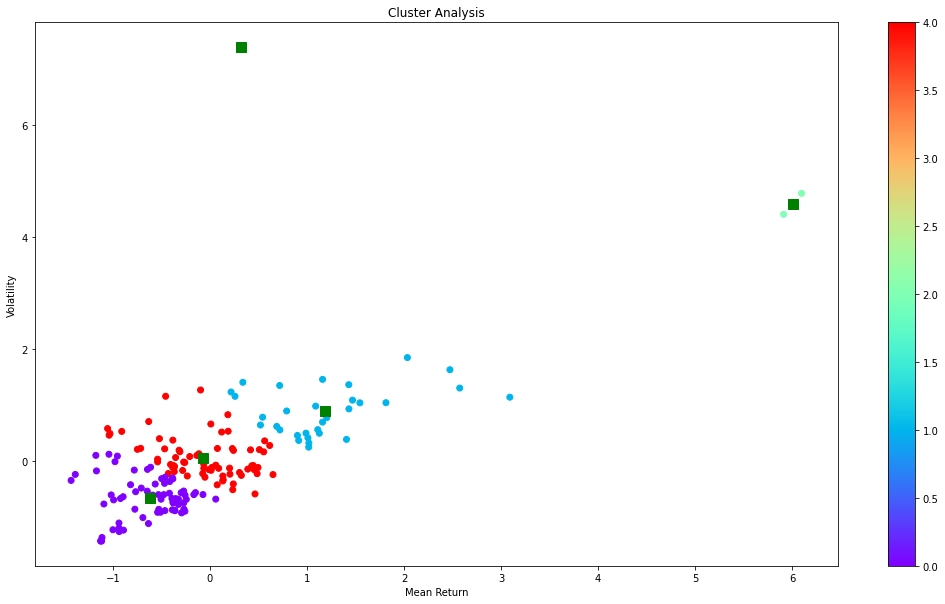

In [24]:
# show results
centroids = kmeans.cluster_centers_
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=kmeans.labels_, cmap='rainbow', label=X.index )
ax.set_title('Cluster Analysis')
ax.set_ylabel('Volatility')
ax.set_xlabel('Mean Return')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [25]:
# return the clustered series
clustered_series = pd.Series(index=X.index, data=kmeans.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series

ABBV    0
ABCB    4
ADPT    4
AGRO    4
AGZ     0
       ..
WTI     1
XLP     0
XME     4
XNCR    0
ZTS     0
Length: 177, dtype: int32

In [26]:
clustered_df = pd.DataFrame(clustered_series)
clustered_df.value_counts()

4    72
0    71
1    31
2     2
3     1
dtype: int64

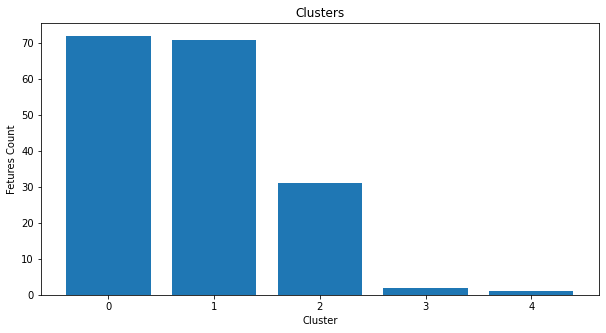

In [27]:
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Fetures Count")
plt.show()

In [28]:
# if there any significant outliers can be detected it should remove from the dataset, but at this point it has been worked with small kind of test dataset which not contains it.
clustered_series_rem_ol = clustered_series[clustered_series < 3]

#### Calculate Cointegration

In [29]:
def calculate_cointegration(series_1, series_2):
  coint_flag = 0
  coint_result = coint(series_1, series_2)
  coint_t = coint_result[0]
  p_value = coint_result[1]
  critical_value = coint_result[2][1]

  model = simplefilter.OLS(series_1, series_2).fit()
  hedge_ratio = model.params[0]
  coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
  return coint_flag, hedge_ratio

In [41]:
# loop through and calculate cointegrated pairs
tested_pairs = []
cointegrated_pairs = []

for base_asset in clustered_series_rem_ol.index:
  base_label = clustered_series_rem_ol[base_asset]

  for compare_asset in clustered_series_rem_ol.index:
    compare_label = clustered_series_rem_ol[compare_asset]

    test_pair = base_asset + compare_asset
    test_pair = ''.join(sorted(test_pair))
    is_tested = test_pair in tested_pairs
    tested_pairs.append(test_pair)

    if compare_asset != base_asset and base_label == compare_label and not is_tested:
      series_1 = data[base_asset].values.astype(float)
      series_2 = data[compare_asset].values.astype(float)
      coint_flag, _ = calculate_cointegration(series_1, series_2)
      if coint_flag == 1:
        cointegrated_pairs.append({
            "base_asset": base_asset,
            "compare_asset": compare_asset,
            "label": base_label
        })

df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
df_coint.head()

KeyboardInterrupt: ignored

In [42]:
df_coint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   base_asset     187 non-null    object
 1   compare_asset  187 non-null    object
 2   label          187 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 5.1+ KB


In [57]:
less_coint_df = df_coint[df_coint['label'] == 1]

In [58]:
less_coint_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 173 to 186
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   base_asset     37 non-null     object
 1   compare_asset  37 non-null     object
 2   label          37 non-null     int32 
dtypes: int32(1), object(2)
memory usage: 1.0+ KB


In [60]:
less_coint_df[:10]

,base_asset,compare_asset,label
173,PUMP,SLCA,1
171,PINS,SVC,1
6,ARCB,BW,1
5,AMRC,CRNC,1
180,SITC,TBBK,1
45,CIR,PUMP,1
33,BW,TBBK,1
58,CYRX,WRLD,1
57,CYRX,LPRO,1
56,CYRX,LBRT,1


In [72]:
less_coint_df["base_asset"].iloc[2]

'ARCB'

In [81]:
def  plot_coint_assets(d, location): 
  asset_1 = d["base_asset"].iloc[location]
  asset_2 = d["compare_asset"].iloc[location]
  asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
  asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()
  plt.figure(1, figsize=(20, 8))
  plt.plot(asset_1_values)
  plt.plot(asset_2_values)
  plt.show()

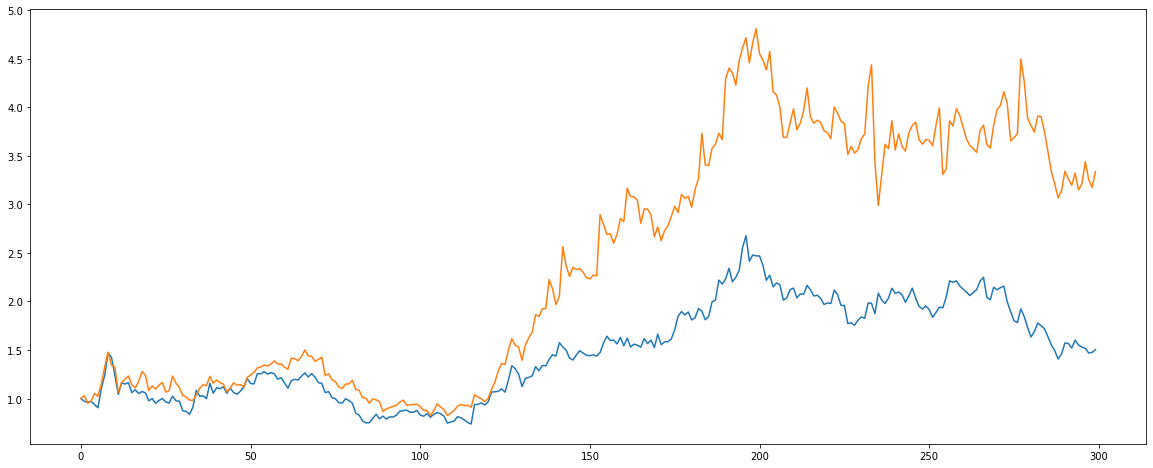

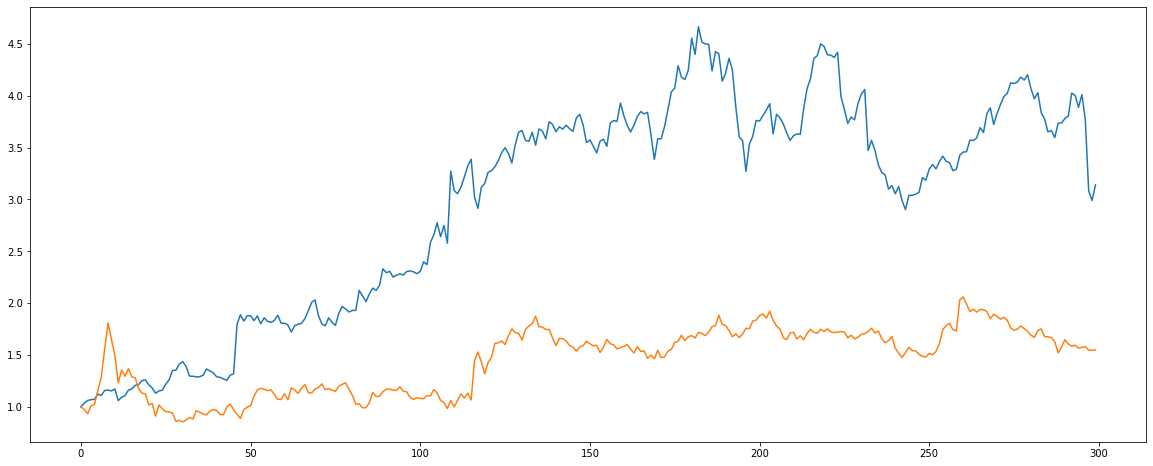

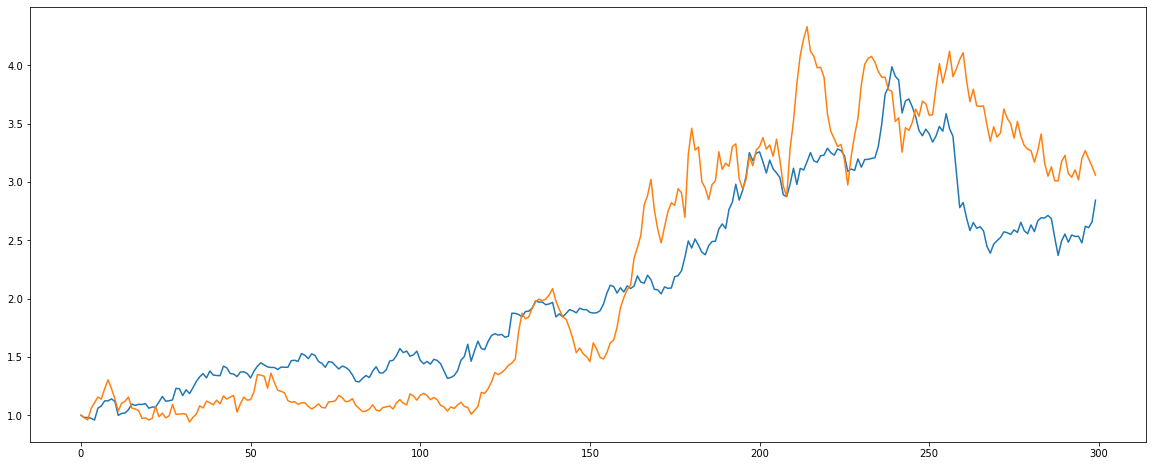

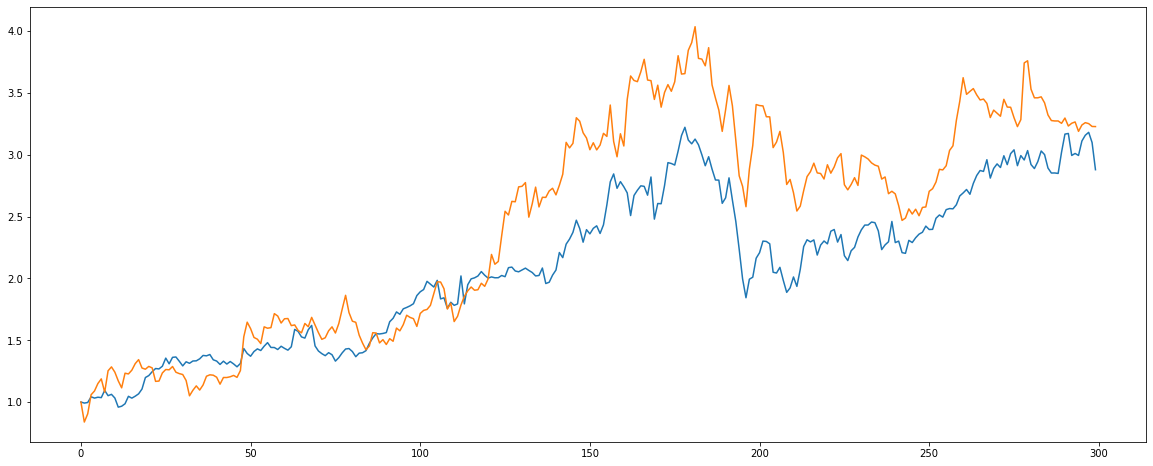

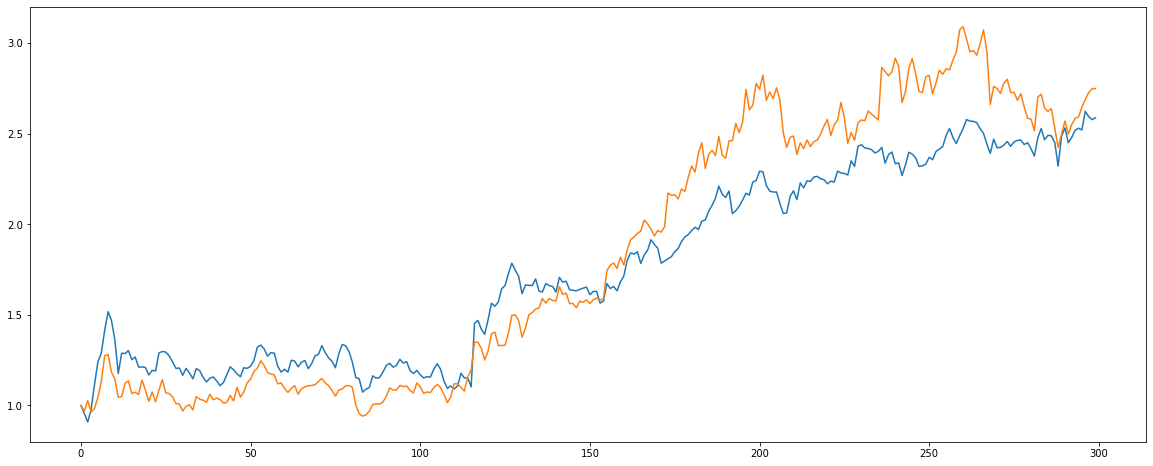

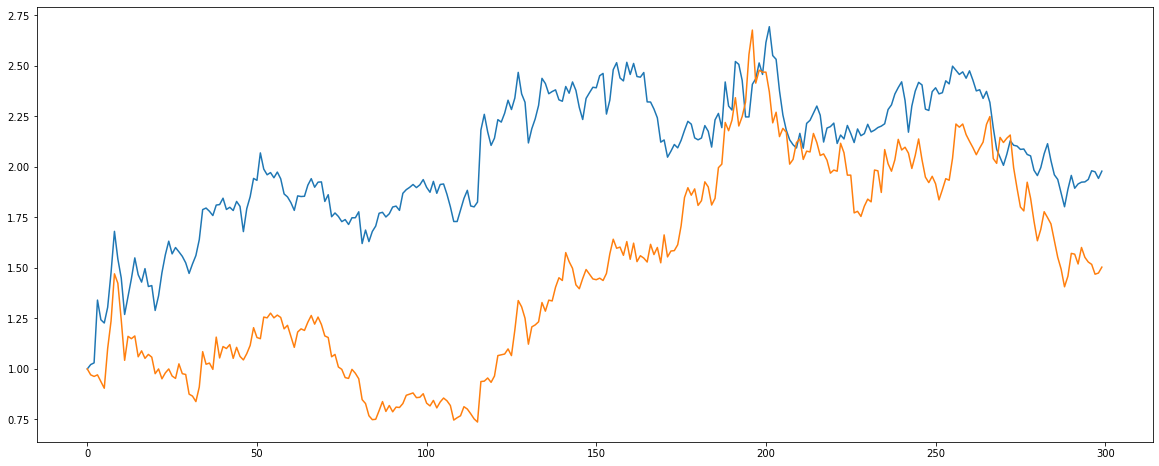

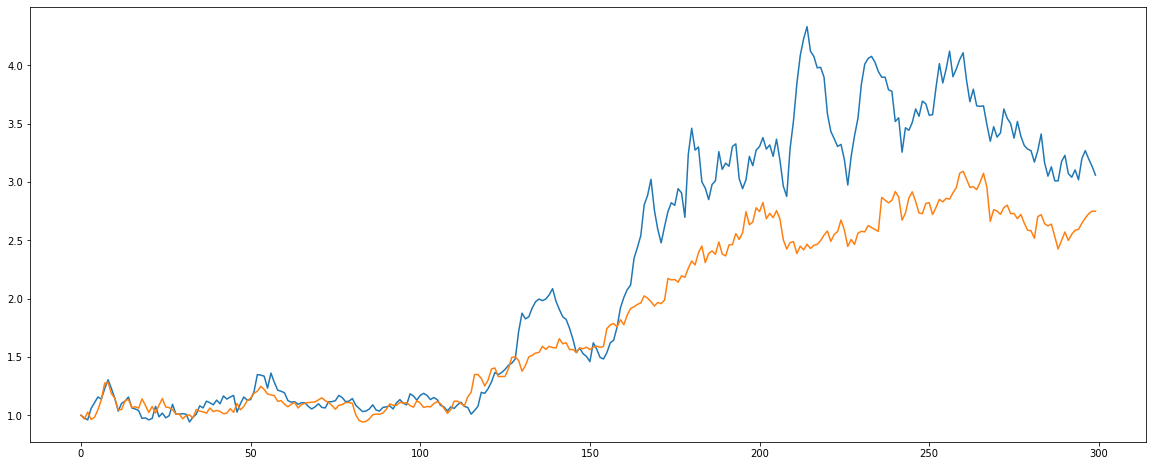

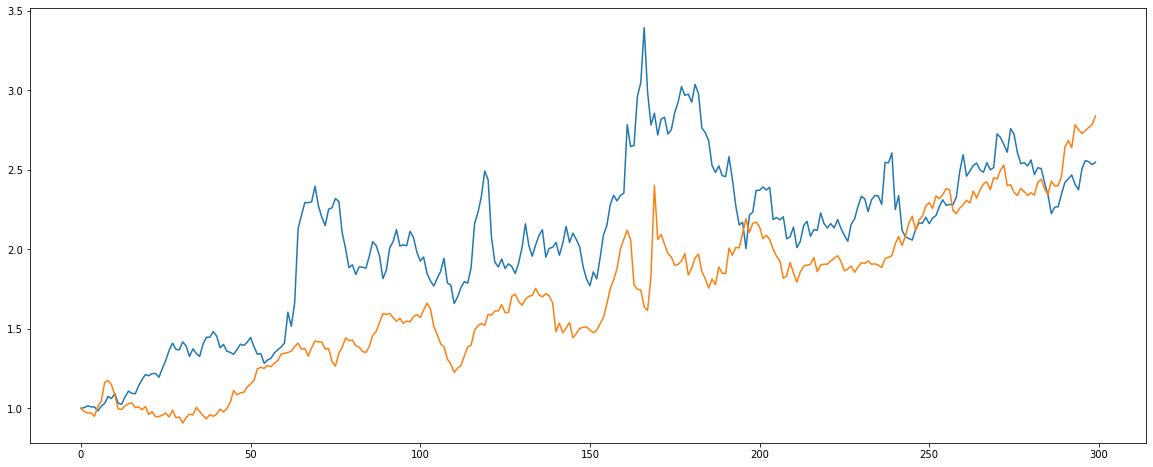

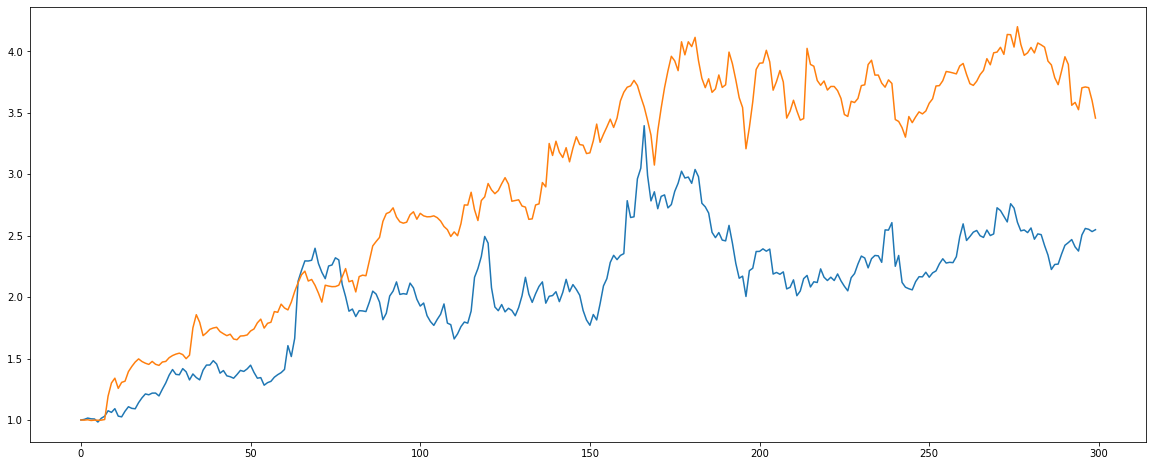

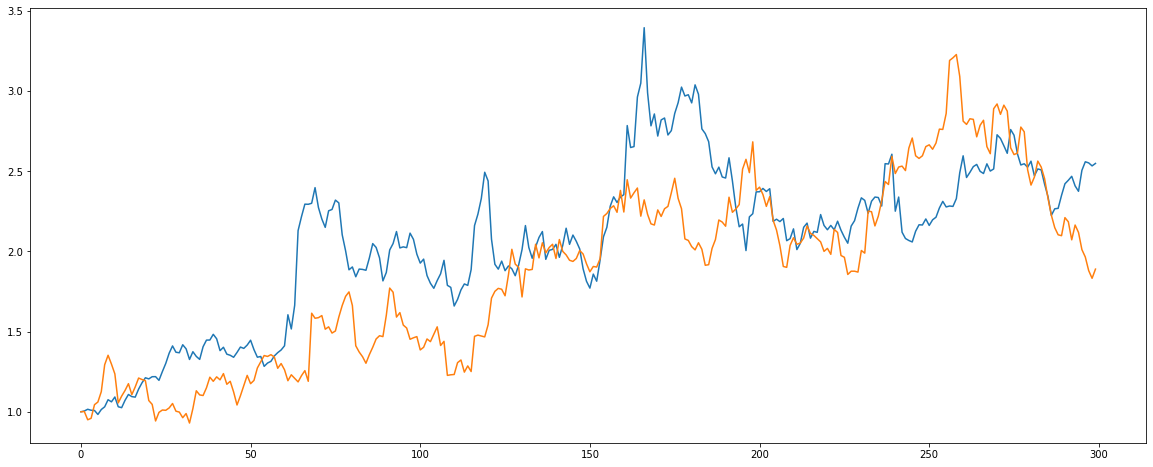

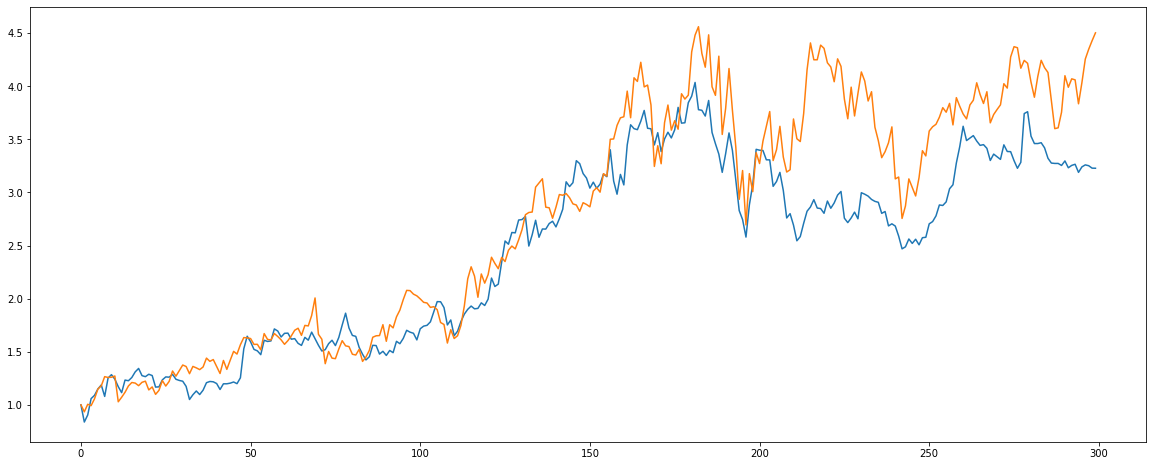

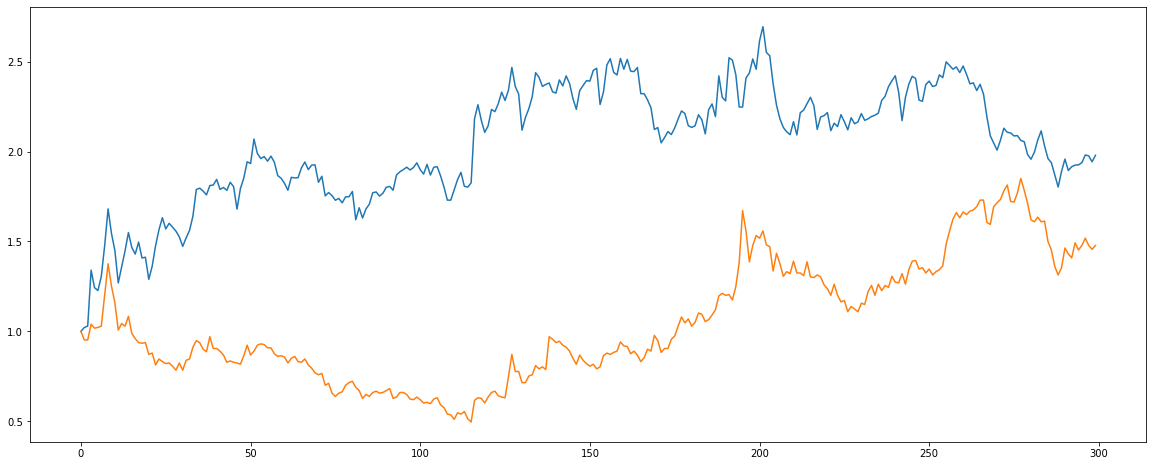

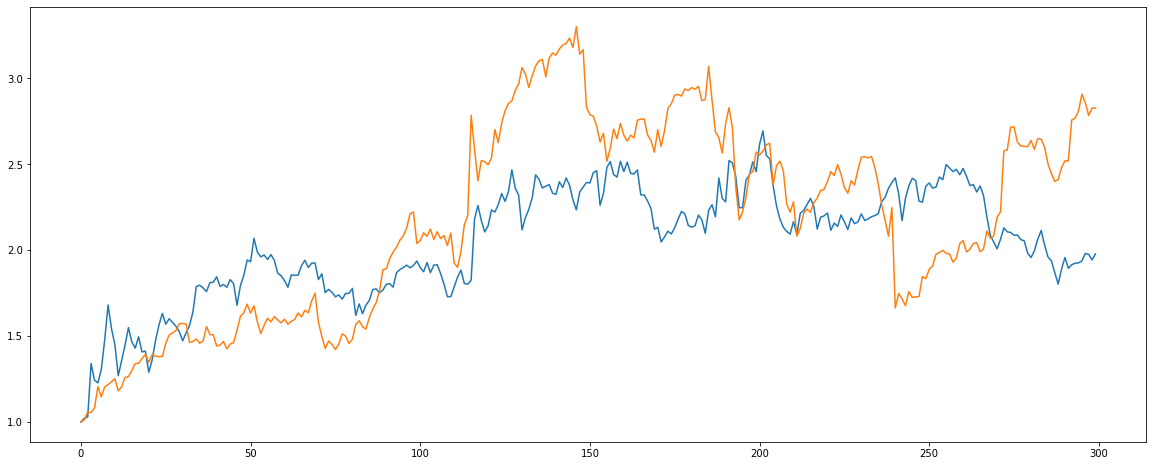

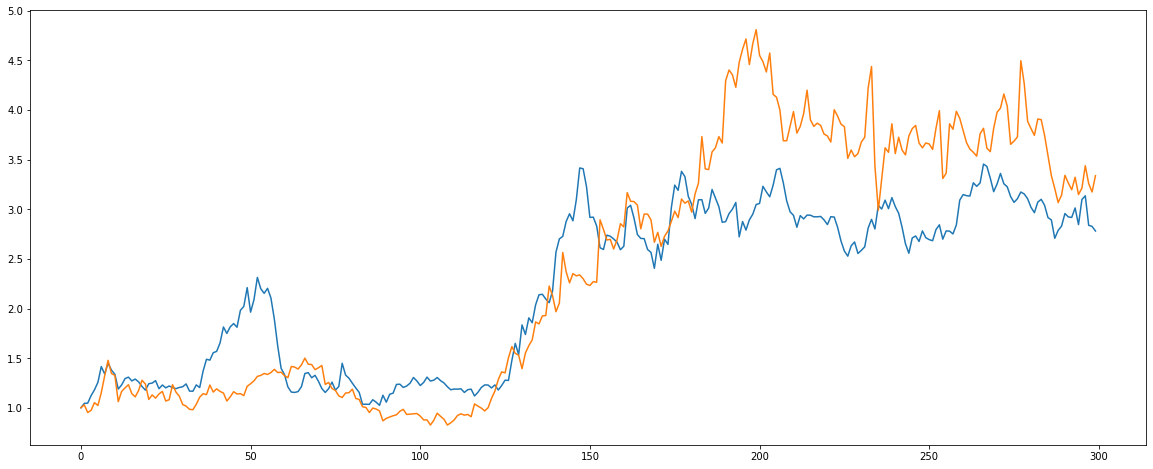

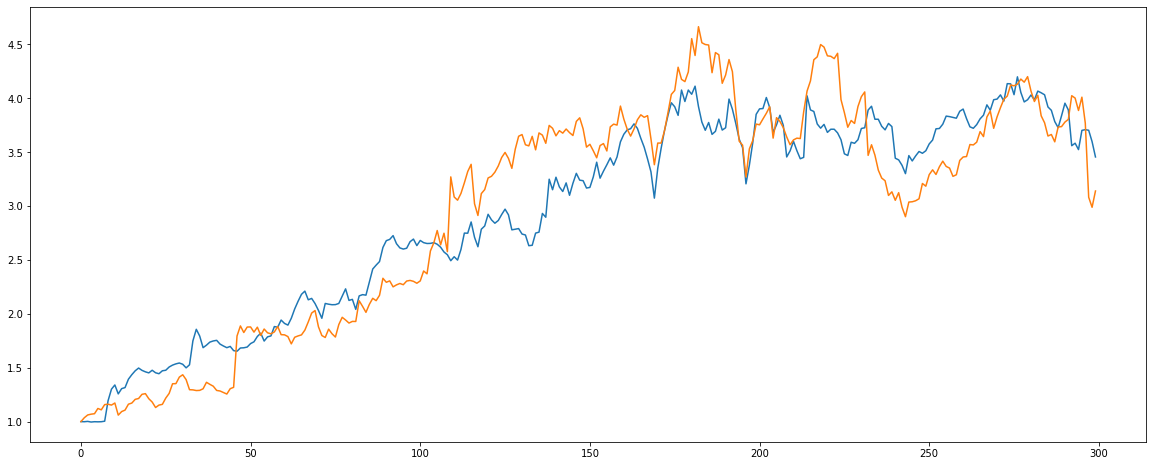

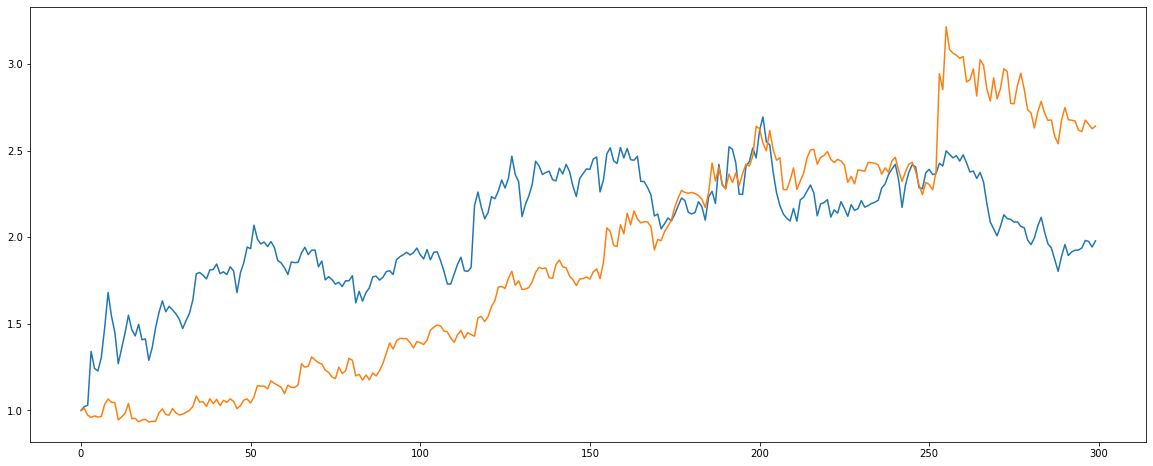

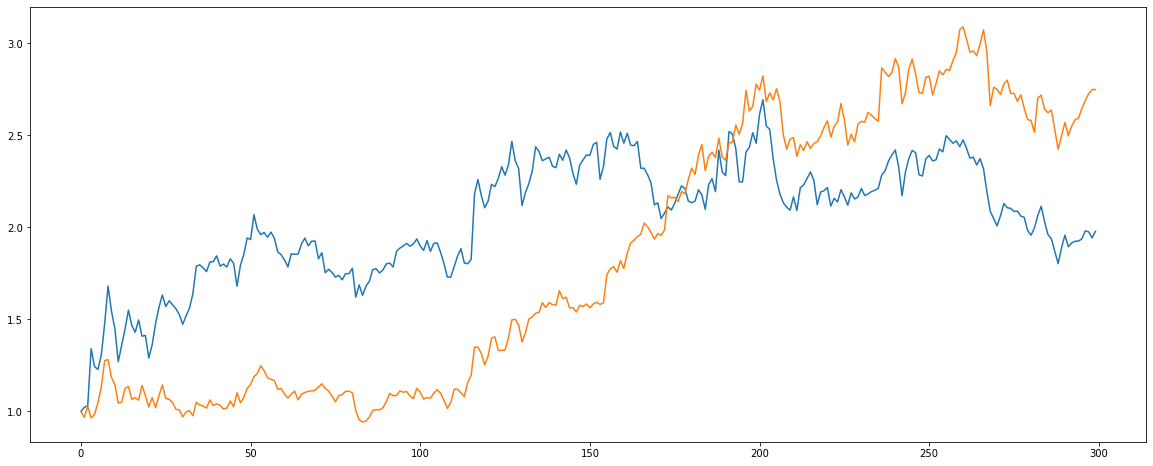

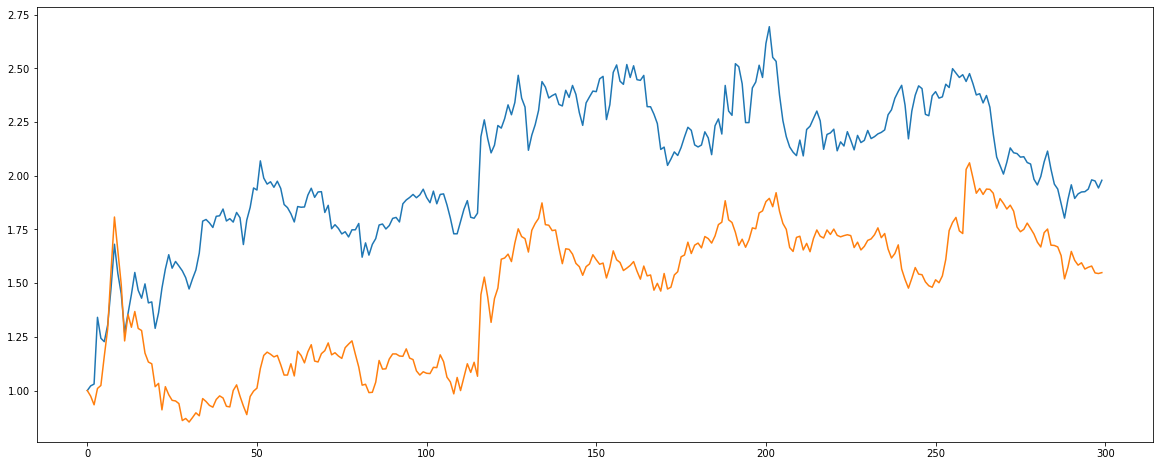

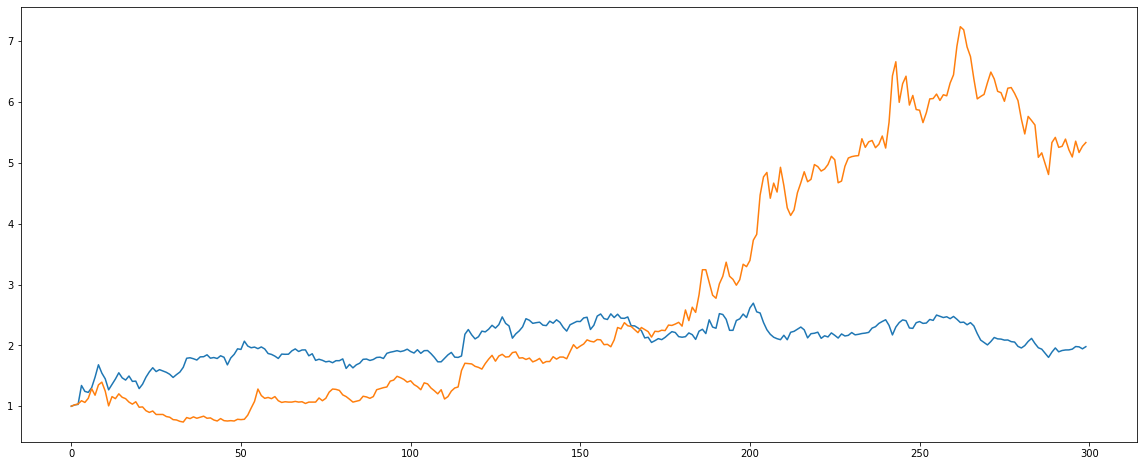

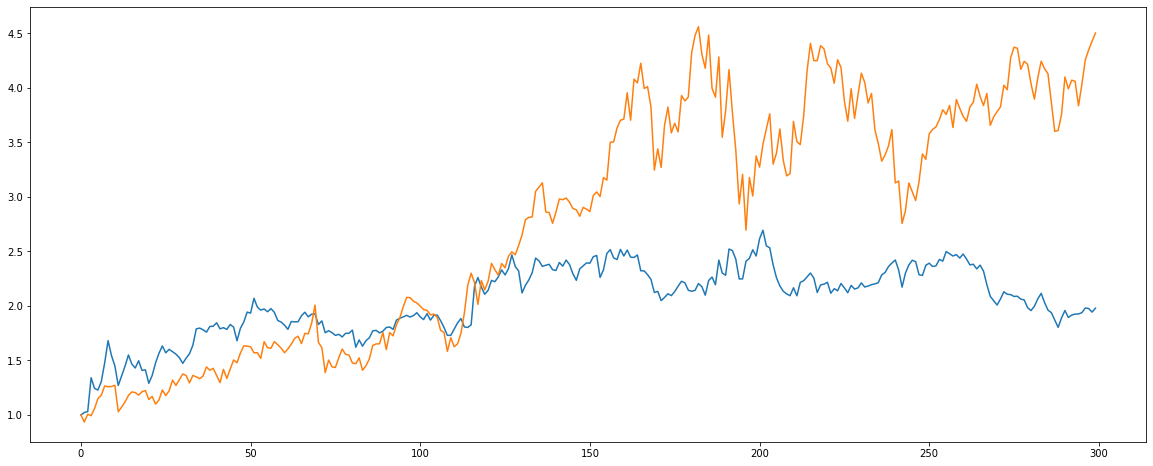

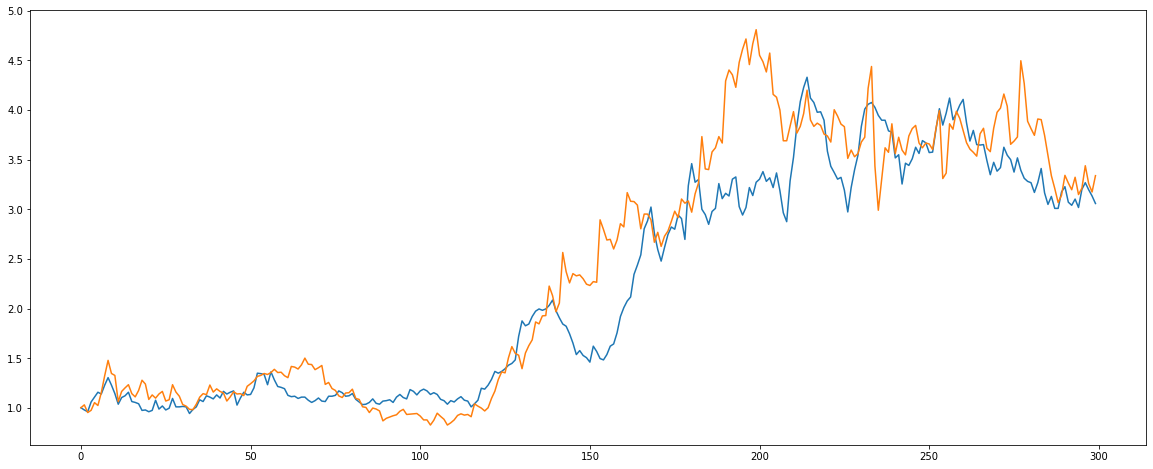

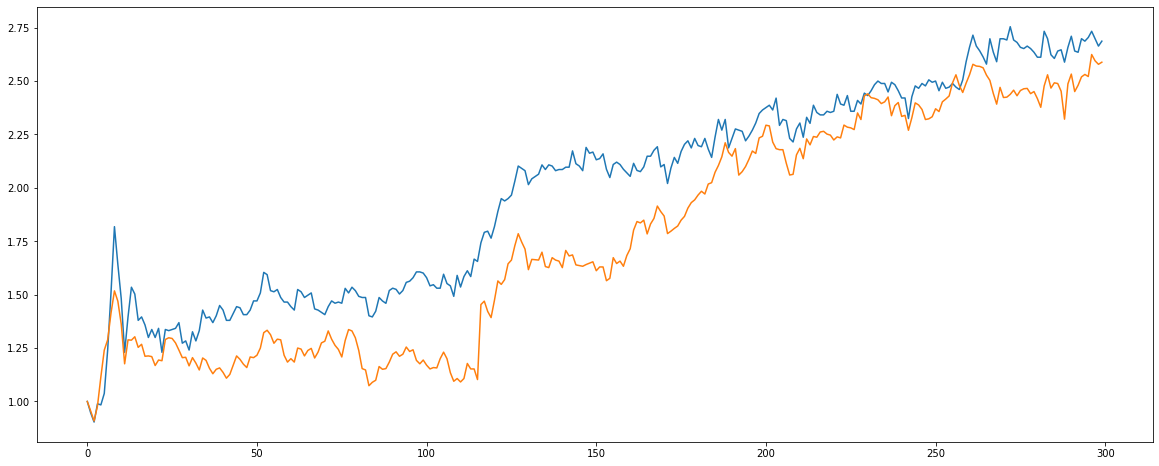

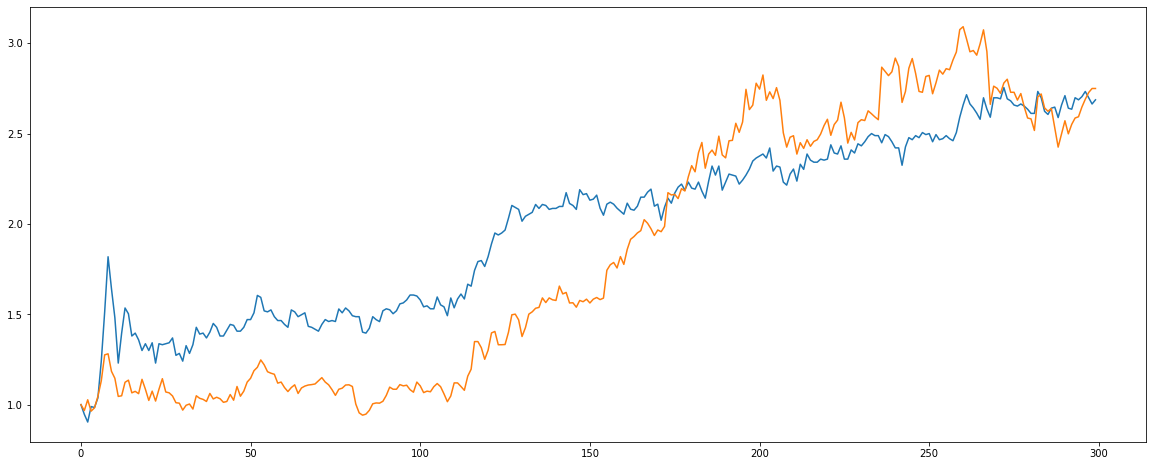

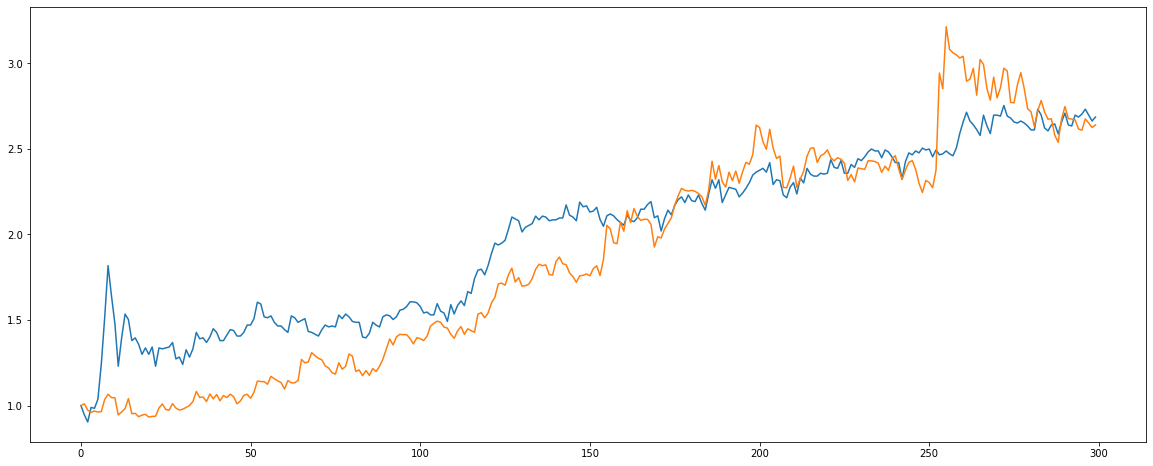

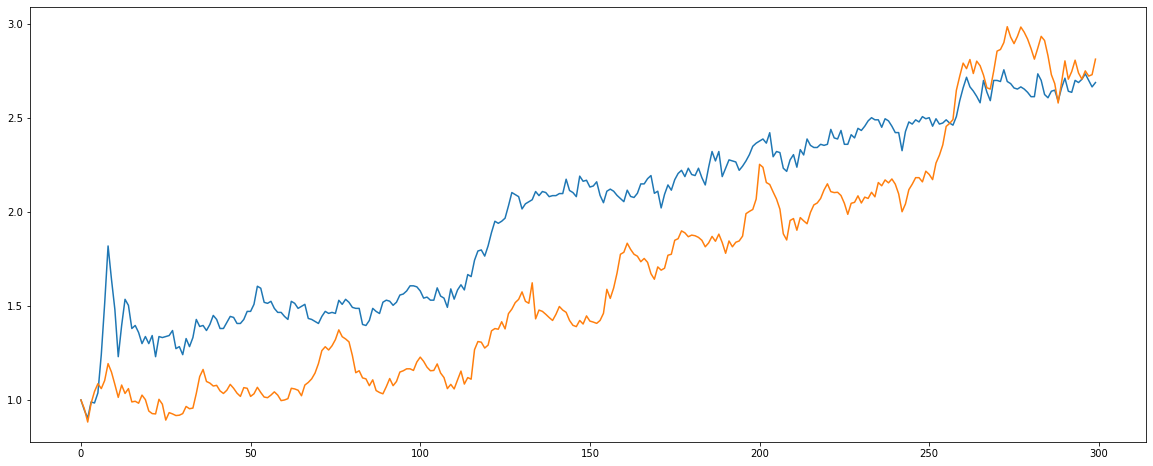

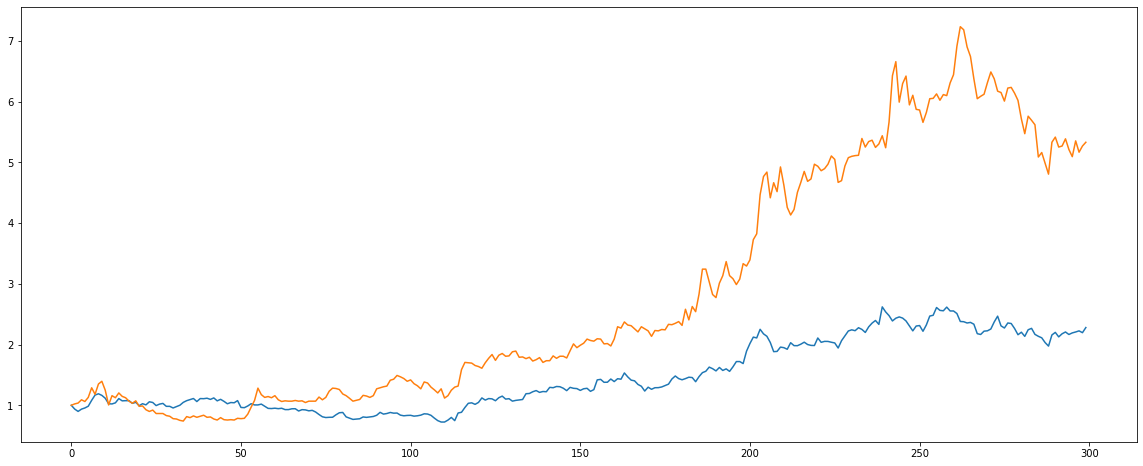

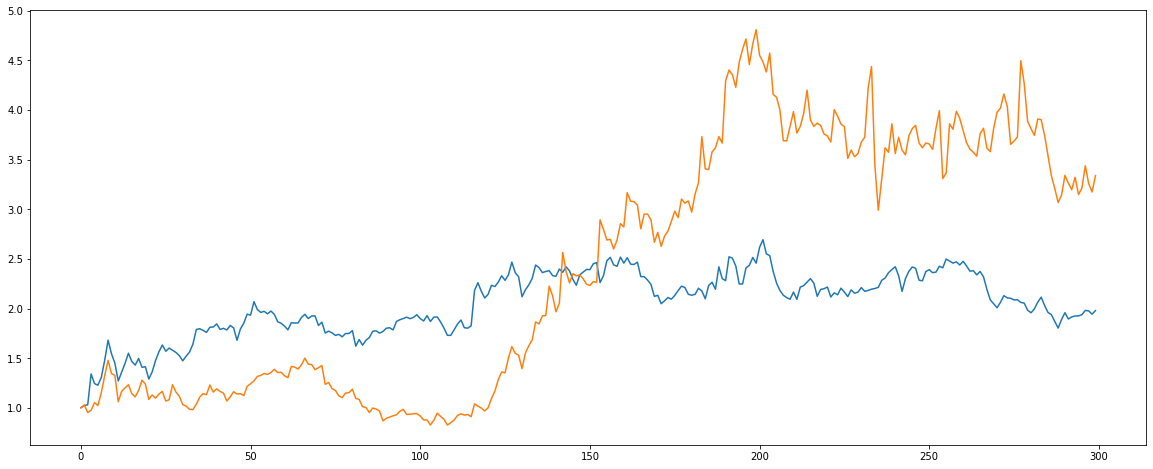

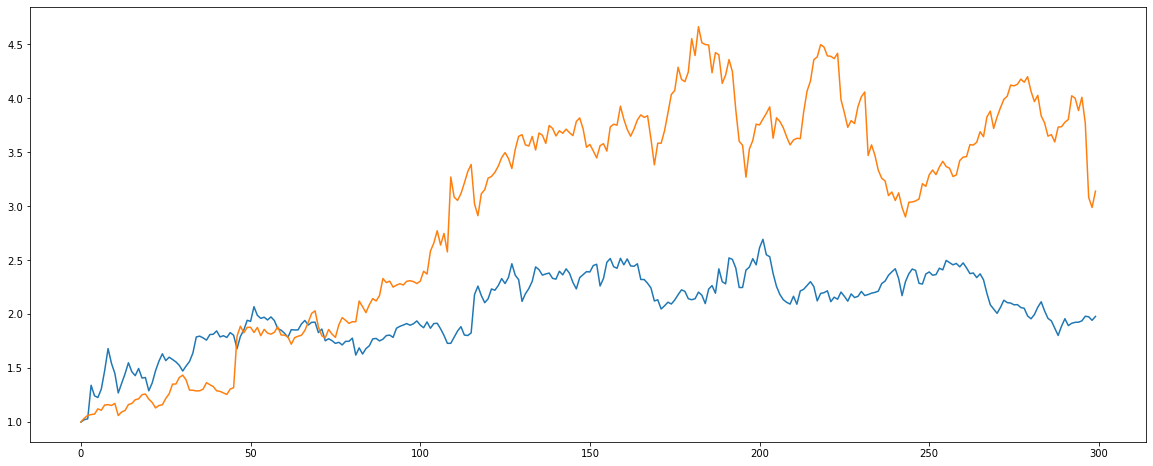

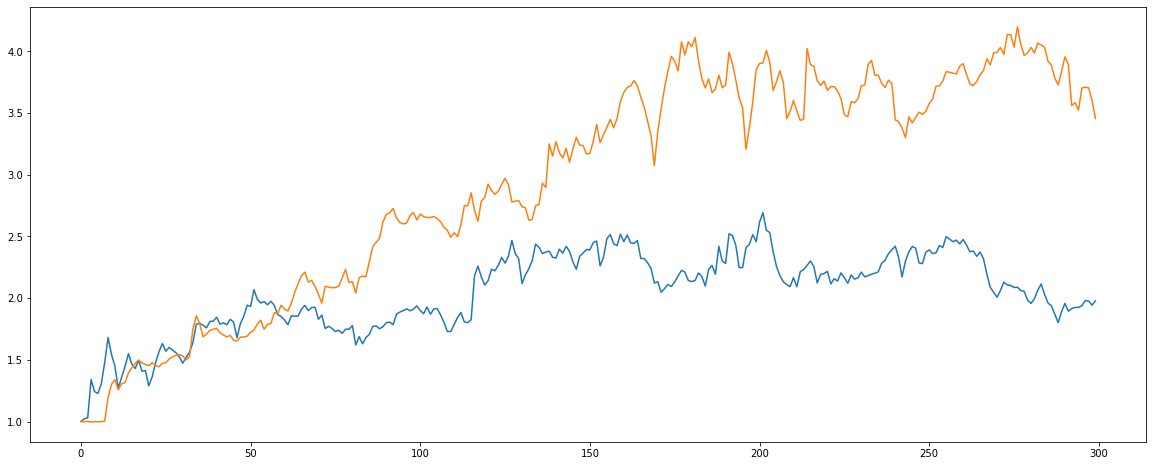

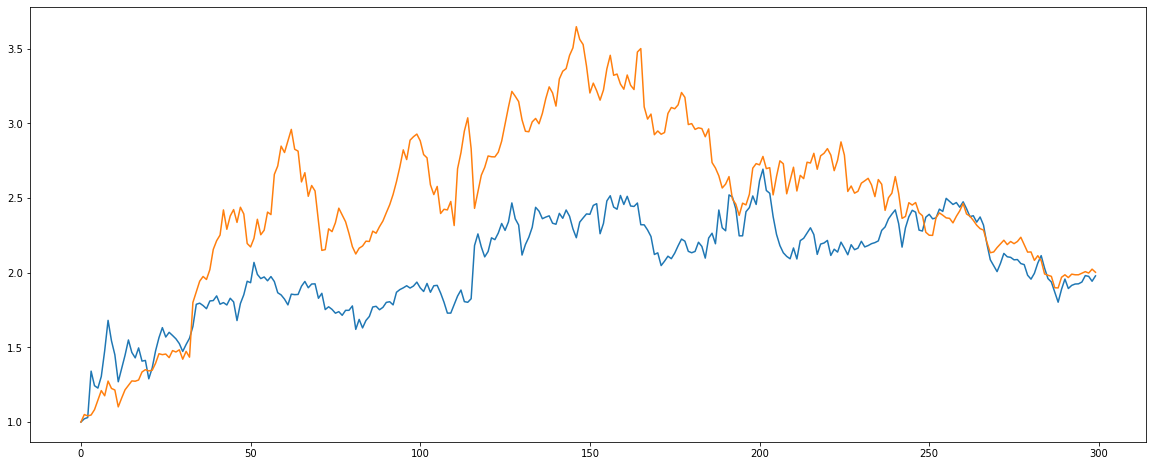

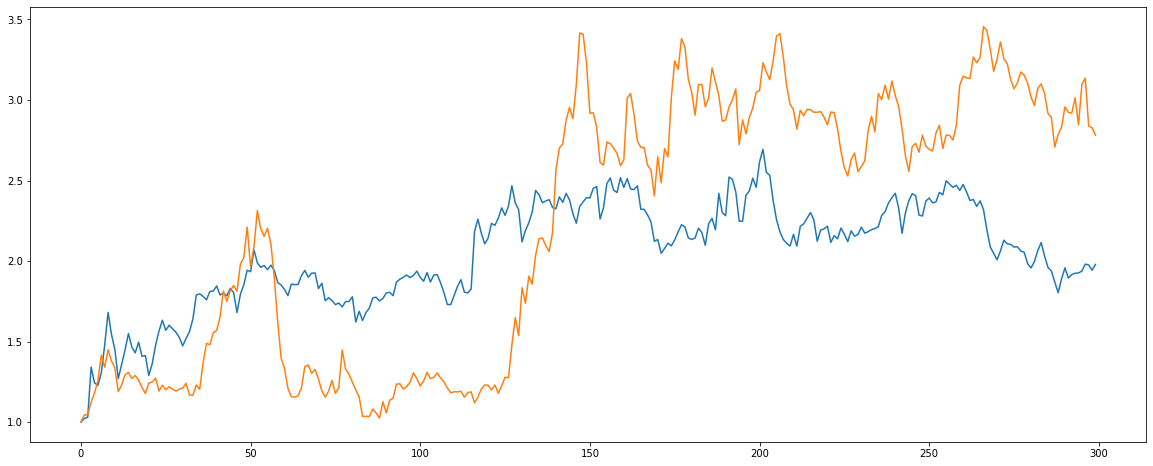

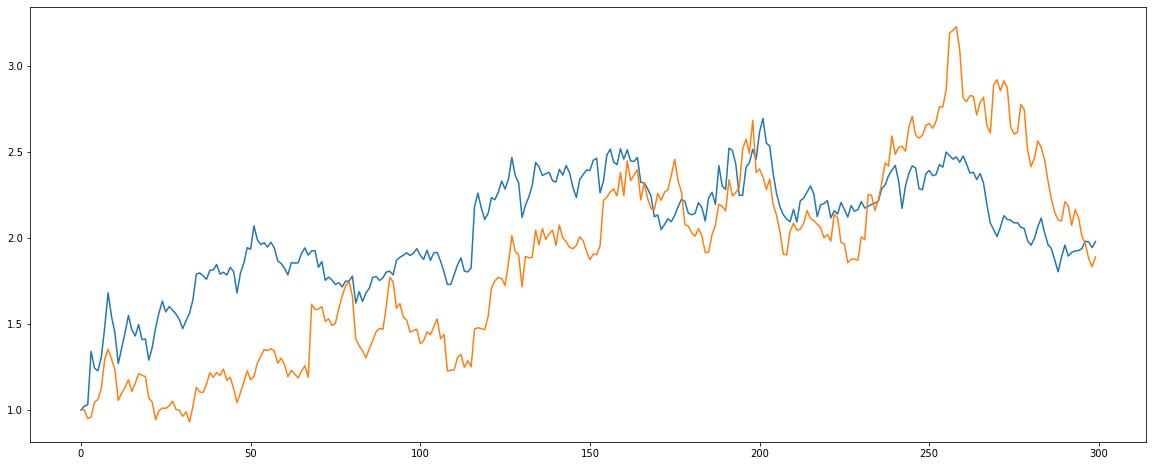

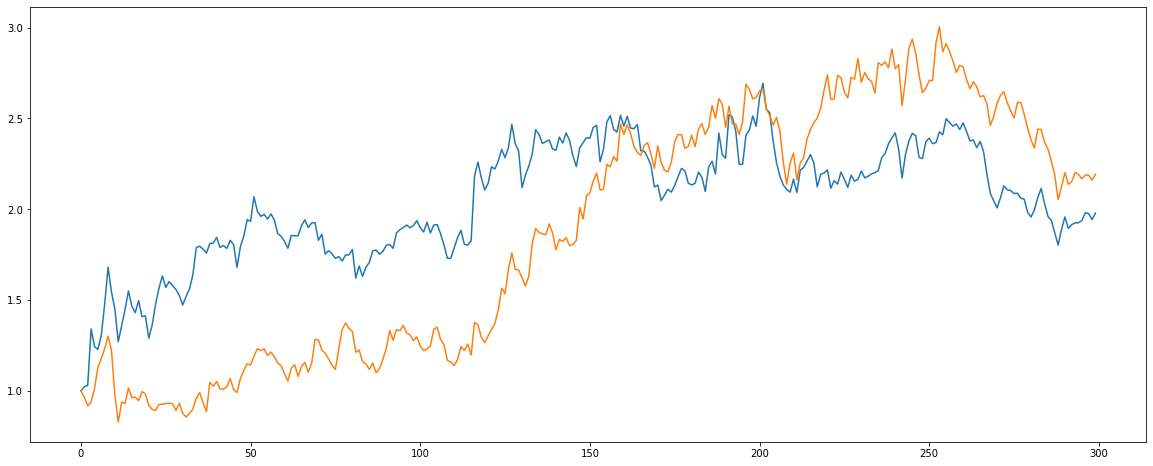

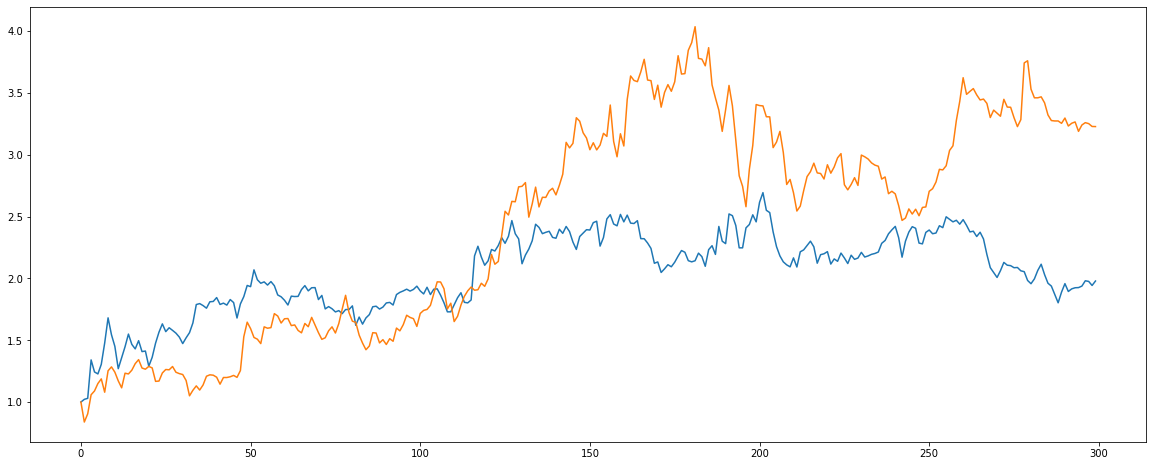

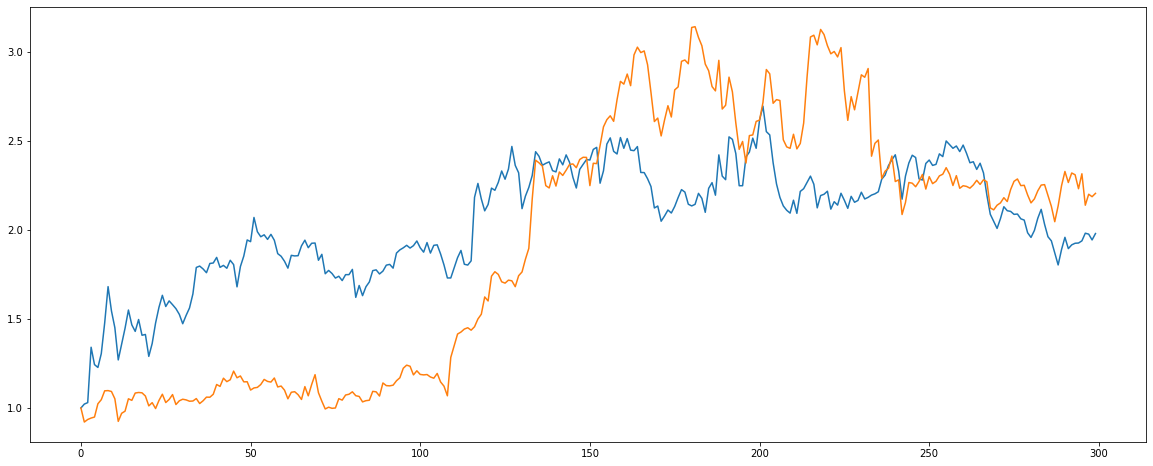

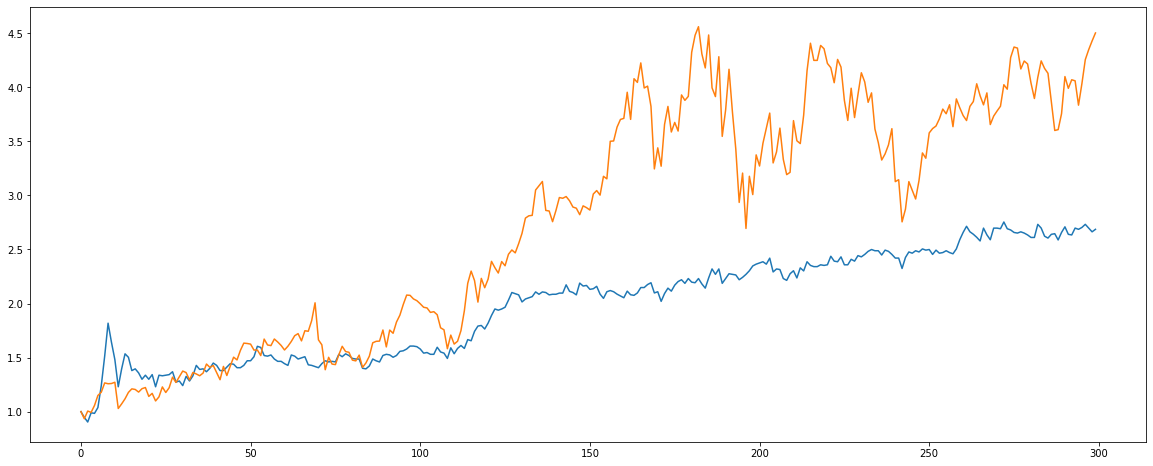

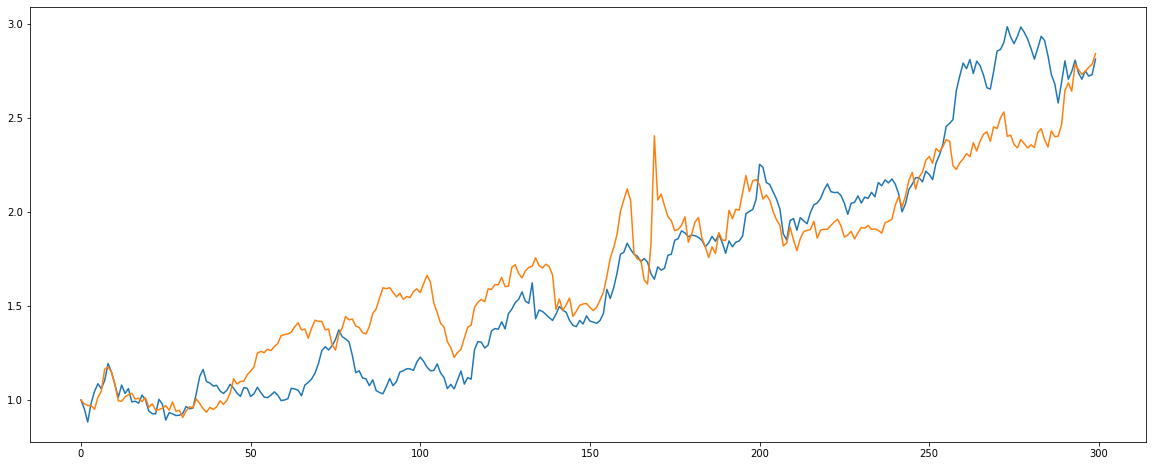

In [83]:
for i in range(len(less_coint_df)):
  plot_coint_assets(less_coint_df, i)